In [89]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import imread, showMatches
from skimage.color import rgb2gray
from scipy.ndimage.filters import convolve
import cv2
import sys
%matplotlib inline

In [92]:
def get_stitched_image(img1, img2, M):

    # Get width and height of input images	
    w1,h1 = img1.shape[:2]
    w2,h2 = img2.shape[:2]

    # Get the canvas dimesions
    img1_dims = np.float32([ [0,0], [0,w1], [h1, w1], [h1,0] ]).reshape(-1,1,2)
    img2_dims_temp = np.float32([ [0,0], [0,w2], [h2, w2], [h2,0] ]).reshape(-1,1,2)


    # Get relative perspective of second image
    img2_dims = cv2.perspectiveTransform(img2_dims_temp, M)

    # Resulting dimensions
    result_dims = np.concatenate( (img1_dims, img2_dims), axis = 0)

    # Getting images together
    # Calculate dimensions of match points
    [x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)

    # Create output array after affine transformation 
    transform_dist = [-x_min,-y_min]
    transform_array = np.array([[1, 0, transform_dist[0]], 
                                [0, 1, transform_dist[1]], 
                                [0,0,1]]) 

    # Warp images to get the resulting image
    result_img = cv2.warpPerspective(img2, transform_array.dot(M), 
                                    (x_max-x_min, y_max-y_min))
    result_img[transform_dist[1]:w1+transform_dist[1], 
                transform_dist[0]:h1+transform_dist[0]] = img1

    # Return the result
    return result_img

# Find SIFT and return Homography Matrix
def get_sift_homography(img1, img2):

    # Initialize SIFT 
    sift = sift = cv2.xfeatures2d.SIFT_create() #cv2.SIFT()

    # Extract keypoints and descriptors
    k1, d1 = sift.detectAndCompute(img1, None)
    k2, d2 = sift.detectAndCompute(img2, None)

    # Bruteforce matcher on the descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1,d2, k=2)

    # Make sure that the matches are good
    verify_ratio = 0.8 # Source: stackoverflow
    verified_matches = []
    for m1,m2 in matches:
        # Add to array only if it's a good match
        if m1.distance < 0.8 * m2.distance:
            verified_matches.append(m1)

    # Mimnum number of matches
    min_matches = 8
    if len(verified_matches) > min_matches:

        # Array to store matching points
        img1_pts = []
        img2_pts = []

        # Add matching points to array
        for match in verified_matches:
            img1_pts.append(k1[match.queryIdx].pt)
            img2_pts.append(k2[match.trainIdx].pt)
        img1_pts = np.float32(img1_pts).reshape(-1,1,2)
        img2_pts = np.float32(img2_pts).reshape(-1,1,2)

        # Compute homography matrix
        M, mask = cv2.findHomography(img1_pts, img2_pts, cv2.RANSAC, 5.0)
        return M
    else:
        print 'Error: Not enough matches'
        exit()

# Equalize Histogram of Color Images
def equalize_histogram_color(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    #img = cv2.cvtColor(img_yuv, cv2.COLOR_RGB2GRAY)
    return img_yuv

def main(img1, img2):
    # Equalize histogram
    img1 = equalize_histogram_color(img1)
    img2 = equalize_histogram_color(img2)

    # Show input images
    #input_images = np.hstack( (img1, img2) )
    #cv2.imshow ('Input Images', input_images)

    # Use SIFT to find keypoints and return homography matrix
    M =  get_sift_homography(img1, img2)

    # Stitch the images together using homography matrix
    result_image = get_stitched_image(img2, img1, M)
    return result_image


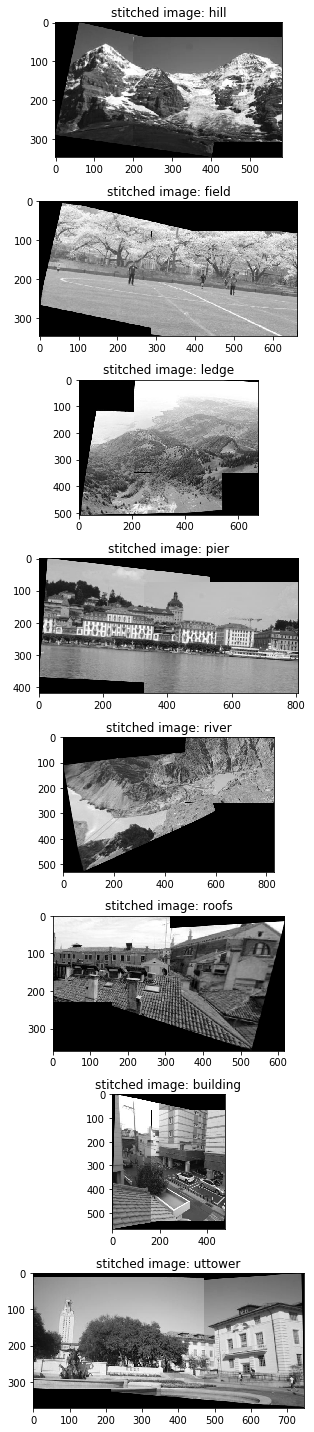

In [94]:
#Image directory
dataDir = os.path.join('..', 'data', 'stitching')

#Read input images
testExamples = ['hill', 'field', 'ledge', 'pier', 'river', 'roofs', 'building', 'uttower']
exampleIndex = 2
imageName1 = '{}1_r.jpg'.format(testExamples[exampleIndex])
imageName2 = '{}2_r.jpg'.format(testExamples[exampleIndex])

im1 = imread(os.path.join(dataDir, imageName1))
im2 = imread(os.path.join(dataDir, imageName2))

itr = 1
plt.figure(figsize=(20, 20))
for example in testExamples:
    imageName1 = '{}1_r.jpg'.format(example)
    imageName2 = '{}2_r.jpg'.format(example)
    img1 = cv2.imread(os.path.join(dataDir, imageName1))
    img2 = cv2.imread(os.path.join(dataDir, imageName2))
    result = (main(img1, img2))
    
    plt.subplot(len(testExamples), 1, itr)
    plt.imshow(result, cmap='gray')
    plt.title('stitched image: {}'.format(example))
    plt.savefig('../output/stitching/{}.jpg'.format(example))
    plt.tight_layout()
    itr += 1

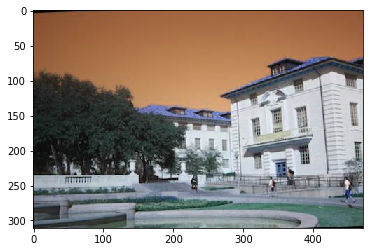

In [85]:
imageName1 = '{}1_r.jpg'.format(example)
imageName2 = '{}2_r.jpg'.format(example)
img1 = cv2.imread(os.path.join(dataDir, imageName1))
img2 = cv2.imread(os.path.join(dataDir, imageName2))

im1 = imread(os.path.join(dataDir, imageName1))
im2 = imread(os.path.join(dataDir, imageName2))

plt.imshow(img1)

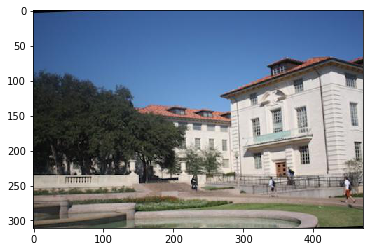

In [86]:
plt.imshow(im1)